In [1]:
import pandas as pd
from ensemble_boxes import *
import numpy as np
from pycocotools.coco import COCO

In [56]:
submission_files = [   
    '/opt/ml/level2_objectdetection-cv-01/mmdetection/work_dirs/dcn/submission_epoch_17.csv',
    "/opt/ml/level2_objectdetection-cv-01/mmdetection/work_dirs/deformable_detr/submission_epoch_38.csv",
    ]
submission_df = [pd.read_csv(file) for file in submission_files]

In [57]:
submission_df

[                                       PredictionString       image_id
 0     0 0.52625865 632.0599 256.97202 748.0738 354.1...  test/0000.jpg
 1     0 0.49654645 753.1117 665.143 900.272 984.4779...  test/0001.jpg
 2     0 0.68650216 165.68085 304.9262 232.10754 584....  test/0002.jpg
 3     0 0.06334426 241.33893 755.0684 997.7945 1021....  test/0003.jpg
 4     0 0.32058284 187.14832 263.9915 858.5221 773.5...  test/0004.jpg
 ...                                                 ...            ...
 4866  0 0.26889715 288.52954 342.92737 665.4406 688....  test/4866.jpg
 4867  0 0.5070548 629.9334 670.1411 778.84296 716.18...  test/4867.jpg
 4868  0 0.29263216 542.43286 537.30304 690.1218 782....  test/4868.jpg
 4869  0 0.40598685 841.2004 10.061462 1024.0 303.598...  test/4869.jpg
 4870  0 0.74282306 95.67239 240.44237 220.39084 330....  test/4870.jpg
 
 [4871 rows x 2 columns],
                                        PredictionString       image_id
 0     0 0.32237172 629.42236 250.77

In [59]:
annotation = '../../dataset/test.json'
coco = COCO(annotation)
image_ids = submission_df[0]['image_id'].tolist()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [108]:
prediction_strings = []
file_names = []
iou_thr = 0.3
weights = [1.5,1]

for i, image_id in enumerate(image_ids):
    prediction_string = ''
    boxes_list = []
    scores_list = []
    labels_list = []
    image_info = coco.loadImgs(i)[0]
    for df in submission_df:
        predict_string = df[df['image_id'] == image_id]['PredictionString'].tolist()[0]
        predict_list = str(predict_string).split()
        
        if len(predict_list)==0 or len(predict_list)==1:
            continue
            
        predict_list = np.reshape(predict_list, (-1, 6))
        box_list = []
        
        for box in predict_list[:, 2:6].tolist():
            box[0] = float(box[0]) / image_info['width']
            box[1] = float(box[1]) / image_info['height']
            box[2] = float(box[2]) / image_info['width']
            box[3] = float(box[3]) / image_info['height']
            box_list.append(box)
            
        boxes_list.append(box_list)
        scores_list.append(list(map(float, predict_list[:, 1].tolist())))
        labels_list.append(list(map(int, predict_list[:, 0].tolist())))
    
    if len(boxes_list):
        boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, weights=weights, iou_thr=iou_thr)
        for box, score, label in zip(boxes, scores, labels):
            prediction_string += str(int(label)) + ' ' + str(score) + ' ' + str(box[0] * image_info['width']) + ' ' + str(box[1] * image_info['height']) + ' ' + str(box[2] * image_info['width']) + ' ' + str(box[3] * image_info['height']) + ' '
    
    prediction_strings.append(prediction_string)
    file_names.append(image_id)

In [109]:
submission = pd.DataFrame()
submission['PredictionString'] = prediction_strings
submission['image_id'] = file_names
submission.to_csv('./Ensemble/submission_ensemble.csv')

submission.head()

,PredictionString,image_id
0,7 0.952637767791748 215.64259338378906 52.9930...,test/0000.jpg
1,5 0.6118592262268067 353.205078125 250.1553497...,test/0001.jpg
2,1 0.9082561492919922 424.48748779296875 268.01...,test/0002.jpg
3,9 0.4173130512237549 172.73187255859375 713.63...,test/0003.jpg
4,1 0.18918482065200806 215.98873901367188 312.5...,test/0004.jpg


In [110]:
import os

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [111]:
img_idx = 0
print(image_ids)

['test/0000.jpg', 'test/0001.jpg', 'test/0002.jpg', 'test/0003.jpg', 'test/0004.jpg', 'test/0005.jpg', 'test/0006.jpg', 'test/0007.jpg', 'test/0008.jpg', 'test/0009.jpg', 'test/0010.jpg', 'test/0011.jpg', 'test/0012.jpg', 'test/0013.jpg', 'test/0014.jpg', 'test/0015.jpg', 'test/0016.jpg', 'test/0017.jpg', 'test/0018.jpg', 'test/0019.jpg', 'test/0020.jpg', 'test/0021.jpg', 'test/0022.jpg', 'test/0023.jpg', 'test/0024.jpg', 'test/0025.jpg', 'test/0026.jpg', 'test/0027.jpg', 'test/0028.jpg', 'test/0029.jpg', 'test/0030.jpg', 'test/0031.jpg', 'test/0032.jpg', 'test/0033.jpg', 'test/0034.jpg', 'test/0035.jpg', 'test/0036.jpg', 'test/0037.jpg', 'test/0038.jpg', 'test/0039.jpg', 'test/0040.jpg', 'test/0041.jpg', 'test/0042.jpg', 'test/0043.jpg', 'test/0044.jpg', 'test/0045.jpg', 'test/0046.jpg', 'test/0047.jpg', 'test/0048.jpg', 'test/0049.jpg', 'test/0050.jpg', 'test/0051.jpg', 'test/0052.jpg', 'test/0053.jpg', 'test/0054.jpg', 'test/0055.jpg', 'test/0056.jpg', 'test/0057.jpg', 'test/0058.jp

22
['0', '0.6397051', '371.27753', '235.99088', '627.4776', '788.99817', '1', '0.75414354', '378.63507', '240.42236', '619.7283', '794.0773']
['0', '0.15672778', '441.22708', '517.5702', '611.2776', '789.0029', '0', '0.07443525', '449.19916', '650.20215', '605.35187', '783.8943', '0', '0.072182156', '377.41724', '298.8495', '481.93207', '762.4822', '0', '0.07190242', '470.19568', '447.51935', '601.8629', '574.4918', '0', '0.05223533', '369.06787', '227.80777', '626.9633', '785.5261', '0', '0.050333675', '372.03717', '288.6906', '613.51575', '781.3525', '0', '0.04911316', '372.01062', '438.12524', '608.69293', '769.6981', '0', '0.04356114', '478.35623', '238.43419', '623.76465', '549.486', '0', '0.037259374', '480.1524', '234.41833', '623.1622', '470.99182', '0', '0.033728924', '479.0022', '240.8301', '621.60645', '526.545', '0', '0.033575263', '414.89957', '302.63654', '609.5481', '776.2281', '0', '0.0328559', '435.60458', '517.51874', '606.42883', '785.9643', '0', '0.03157681', '376.9

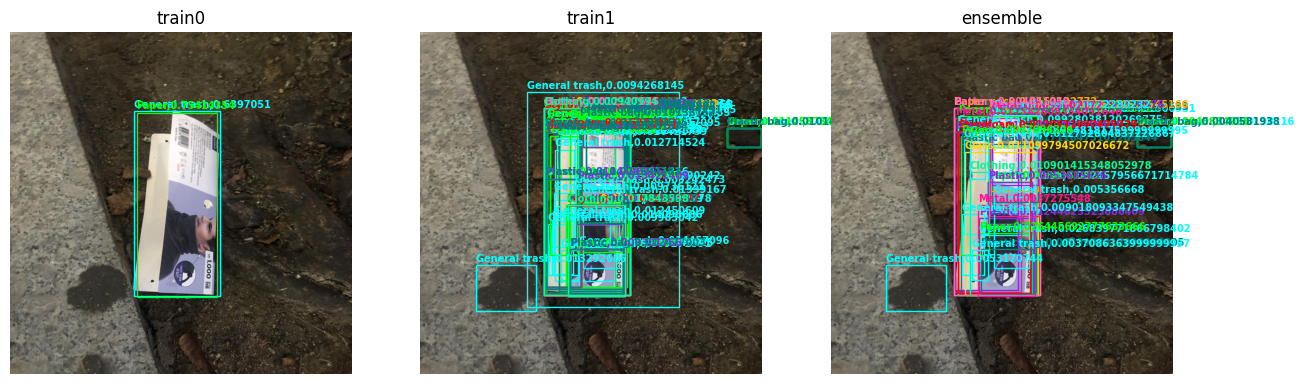

In [133]:
colors = ['cyan', 'lime', 'orange', 'deeppink', 'gold', 'blueviolet', 'red', 'teal', 'hotpink', 'mediumspringgreen']
category = ["General trash", "Paper", "Paper pack", "Metal", "Glass", "Plastic", "Styrofoam", "Plastic bag", "Battery", "Clothing"]

fig, axes = plt.subplots(1, 3, figsize=(15, 7))
image_id = image_ids[img_idx]
img_idx+=1
print(img_idx)
img_path = os.path.join("../../dataset/", image_id)
                        
informations = {f"train{idx}" : df for idx, df in enumerate(submission_df)}
informations['ensemble'] = submission
for i, (name, df) in enumerate(informations.items()):
    predict_list = str(df[df['image_id'] == image_id]['PredictionString'].tolist()[0]).split()
    x = i % 3
    # y = i // 3
    img = Image.open(img_path)
    print(predict_list)

    axes[x].imshow(img)
    axes[x].axis('off')
    axes[x].set_title(name)
    if len(predict_list)%6 != 0:
        raise
    for idx in range(len(predict_list)//6):
        label, confidence, x_min, y_min, x_max, y_max = int(predict_list[6*idx + 0]), float(predict_list[6*idx + 1]), float(predict_list[6*idx + 2]), float(predict_list[6*idx + 3]), float(predict_list[6*idx + 4]), float(predict_list[6*idx + 5])
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min, linewidth=1, edgecolor=colors[label], facecolor='none')
        axes[x].add_patch(rect)
        axes[x].text(x_min, y_min-10, f"{category[label]}", color=colors[label], fontsize=7, weight='bold')
fig.set_tight_layout
plt.show()